In [27]:
import csv

import numpy as np
import tensorflow as tf
from sklearn import model_selection
import os

In [28]:
RANDOM_SEED = 42
NUM_CLASSES = 25
dataset = 'keypoint_classifier/keypoint_key_letters_right_augmented.csv'
model_save_path = 'keypoint_classifier/GRU_model_right_augmented.hdf5'

In [29]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [30]:

X_train = X_train[:, None, :]
print(X_train.shape)

(988, 1, 42)


In [31]:
X_test = X_test[:, None, :]
print(X_test.shape)

(330, 1, 42)


In [32]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.layers import GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(1,42)))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [33]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 1, 50)             14100     
                                                                 
 dropout_6 (Dropout)         (None, 1, 50)             0         
                                                                 
 gru_3 (GRU)                 (None, 100)               45600     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 25)                2525      
                                                                 
Total params: 62,225
Trainable params: 62,225
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
1/7 [===>..........................] - ETA: 13s - loss: 3.2143 - accuracy: 0.0234
Epoch 1: saving model to keypoint_classifier\GRU_model_right_augmented.hdf5
7/7 [==============================] - 3s 89ms/step - loss: 3.2045 - accuracy: 0.0557 - val_loss: 3.1923 - val_accuracy: 0.0758
Epoch 2/500
1/7 [===>..........................] - ETA: 0s - loss: 3.1852 - accuracy: 0.1016
Epoch 2: saving model to keypoint_classifier\GRU_model_right_augmented.hdf5
7/7 [==============================] - 0s 12ms/step - loss: 3.1698 - accuracy: 0.1367 - val_loss: 3.1616 - val_accuracy: 0.1061
Epoch 3/500
1/7 [===>..........................] - ETA: 0s - loss: 3.1437 - accuracy: 0.1484
Epoch 3: saving model to keypoint_classifier\GRU_model_right_augmented.hdf5
7/7 [==============================] - 0s 11ms/step - loss: 3.1292 - accuracy: 0.1481 - val_loss: 3.1220 - val_accuracy: 0.1010
Epoch 4/500
1/7 [===>..........................] - ETA: 0s - loss: 3.0869 - accuracy: 0.1641
Epoch 4: saving

11/11 [==============================] - 1s 1ms/step


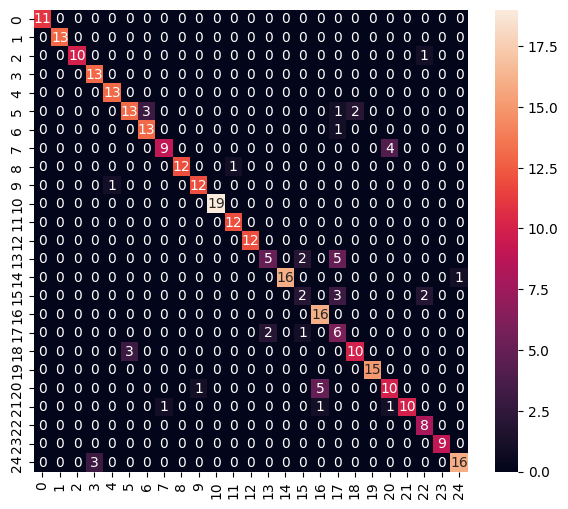

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        13
           2       1.00      0.91      0.95        11
           3       0.81      1.00      0.90        13
           4       0.93      1.00      0.96        13
           5       0.81      0.68      0.74        19
           6       0.81      0.93      0.87        14
           7       0.90      0.69      0.78        13
           8       1.00      0.92      0.96        13
           9       0.92      0.92      0.92        13
          10       1.00      1.00      1.00        19
          11       0.92      1.00      0.96        12
          12       1.00      1.00      1.00        12
          13       0.71      0.42      0.53        12
          14       1.00      0.94      0.97        17
          15       0.40      0.29      0.33         7
          16       0.73      1.00      0.84        16
     

In [35]:
# callback needs to be done better, but still accuracy 86%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [36]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        11
           1      1.000     1.000     1.000        13
           2      1.000     0.909     0.952        11
           3      0.812     1.000     0.897        13
           4      0.929     1.000     0.963        13
           5      0.812     0.684     0.743        19
           6      0.812     0.929     0.867        14
           7      0.900     0.692     0.783        13
           8      1.000     0.923     0.960        13
           9      0.923     0.923     0.923        13
          10      1.000     1.000     1.000        19
          11      0.923     1.000     0.960        12
          12      1.000     1.000     1.000        12
          13      0.714     0.417     0.526        12
          14      1.000     0.941     0.970        17
          15      0.400     0.286     0.333         7
          16      0.727     1.000     0.842        16
          17      0.375    

In [37]:
model_save_path = 'keypoint_classifier/LSTM_model_right_augmented.hdf5'
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1,2*21)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [38]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 50)             18600     
                                                                 
 dropout_8 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 25)                2525      
                                                                 
Total params: 81,525
Trainable params: 81,525
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
1/7 [===>..........................] - ETA: 13s - loss: 3.2193 - accuracy: 0.0312
Epoch 1: saving model to keypoint_classifier\LSTM_model_right_augmented.hdf5
7/7 [==============================] - 3s 97ms/step - loss: 3.2169 - accuracy: 0.0658 - val_loss: 3.2131 - val_accuracy: 0.0606
Epoch 2/500
1/7 [===>..........................] - ETA: 0s - loss: 3.2128 - accuracy: 0.0312
Epoch 2: saving model to keypoint_classifier\LSTM_model_right_augmented.hdf5
7/7 [==============================] - 0s 10ms/step - loss: 3.2083 - accuracy: 0.0911 - val_loss: 3.2062 - val_accuracy: 0.0960
Epoch 3/500
1/7 [===>..........................] - ETA: 0s - loss: 3.1997 - accuracy: 0.1484
Epoch 3: saving model to keypoint_classifier\LSTM_model_right_augmented.hdf5
7/7 [==============================] - 0s 11ms/step - loss: 3.1975 - accuracy: 0.1329 - val_loss: 3.1960 - val_accuracy: 0.1010
Epoch 4/500
1/7 [===>..........................] - ETA: 0s - loss: 3.1881 - accuracy: 0.1562
Epoch 4: sav

11/11 [==============================] - 1s 1ms/step


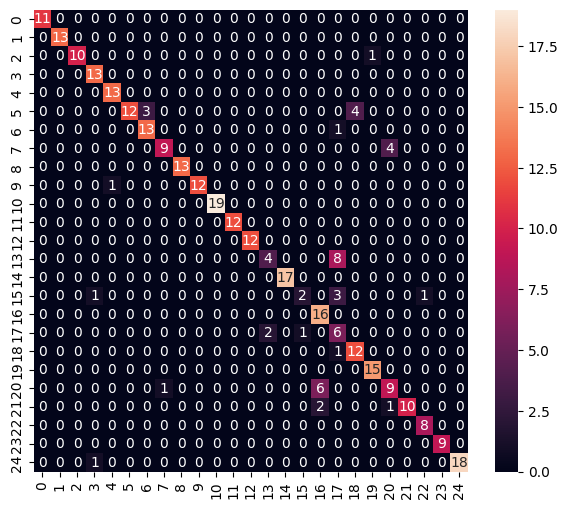

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        13
           2       1.00      0.91      0.95        11
           3       0.87      1.00      0.93        13
           4       0.93      1.00      0.96        13
           5       1.00      0.63      0.77        19
           6       0.81      0.93      0.87        14
           7       0.90      0.69      0.78        13
           8       1.00      1.00      1.00        13
           9       1.00      0.92      0.96        13
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00        12
          13       0.67      0.33      0.44        12
          14       1.00      1.00      1.00        17
          15       0.67      0.29      0.40         7
          16       0.67      1.00      0.80        16
     

In [40]:
# callback needs to be done better, but still accuracy 86%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [41]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        11
           1      1.000     1.000     1.000        13
           2      1.000     0.909     0.952        11
           3      0.867     1.000     0.929        13
           4      0.929     1.000     0.963        13
           5      1.000     0.632     0.774        19
           6      0.812     0.929     0.867        14
           7      0.900     0.692     0.783        13
           8      1.000     1.000     1.000        13
           9      1.000     0.923     0.960        13
          10      1.000     1.000     1.000        19
          11      1.000     1.000     1.000        12
          12      1.000     1.000     1.000        12
          13      0.667     0.333     0.444        12
          14      1.000     1.000     1.000        17
          15      0.667     0.286     0.400         7
          16      0.667     1.000     0.800        16
          17      0.316    

In [42]:
model_save_path = 'keypoint_classifier/SimpleRNN_model_right_augmented.hdf5'
from keras.layers import SimpleRNN
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(1,2*21)))
model.add(Dropout(0.2))
model.add(SimpleRNN(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [43]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 1, 50)             4650      
                                                                 
 dropout_10 (Dropout)        (None, 1, 50)             0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 100)               15100     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 25)                2525      
                                                                 
Total params: 22,275
Trainable params: 22,275
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
1/7 [===>..........................] - ETA: 6s - loss: 3.2811 - accuracy: 0.0234
Epoch 1: saving model to keypoint_classifier\SimpleRNN_model_right_augmented.hdf5
7/7 [==============================] - 1s 43ms/step - loss: 3.2245 - accuracy: 0.0392 - val_loss: 3.0877 - val_accuracy: 0.0960
Epoch 2/500
1/7 [===>..........................] - ETA: 0s - loss: 3.0931 - accuracy: 0.0938
Epoch 2: saving model to keypoint_classifier\SimpleRNN_model_right_augmented.hdf5
7/7 [==============================] - 0s 9ms/step - loss: 3.0488 - accuracy: 0.1038 - val_loss: 2.9644 - val_accuracy: 0.1566
Epoch 3/500
1/7 [===>..........................] - ETA: 0s - loss: 3.0351 - accuracy: 0.1562
Epoch 3: saving model to keypoint_classifier\SimpleRNN_model_right_augmented.hdf5
7/7 [==============================] - 0s 9ms/step - loss: 2.9307 - accuracy: 0.1759 - val_loss: 2.8494 - val_accuracy: 0.2475
Epoch 4/500
1/7 [===>..........................] - ETA: 0s - loss: 2.8170 - accuracy: 0.2109


11/11 [==============================] - 0s 1ms/step


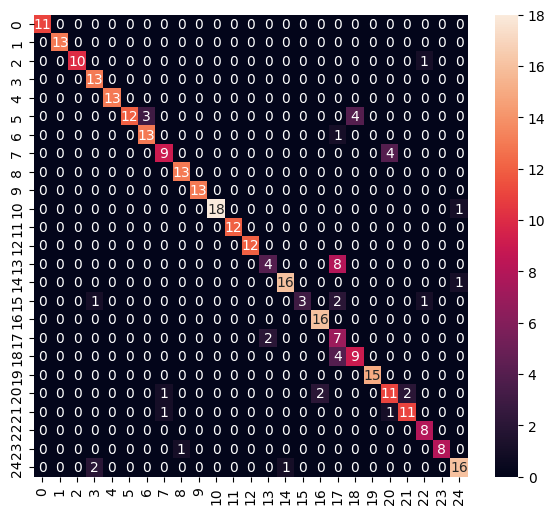

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        13
           2       1.00      0.91      0.95        11
           3       0.81      1.00      0.90        13
           4       1.00      1.00      1.00        13
           5       1.00      0.63      0.77        19
           6       0.81      0.93      0.87        14
           7       0.82      0.69      0.75        13
           8       0.93      1.00      0.96        13
           9       1.00      1.00      1.00        13
          10       1.00      0.95      0.97        19
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00        12
          13       0.67      0.33      0.44        12
          14       0.94      0.94      0.94        17
          15       1.00      0.43      0.60         7
          16       0.89      1.00      0.94        16
     

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [46]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        11
           1      1.000     1.000     1.000        13
           2      1.000     0.909     0.952        11
           3      0.812     1.000     0.897        13
           4      1.000     1.000     1.000        13
           5      1.000     0.632     0.774        19
           6      0.812     0.929     0.867        14
           7      0.818     0.692     0.750        13
           8      0.929     1.000     0.963        13
           9      1.000     1.000     1.000        13
          10      1.000     0.947     0.973        19
          11      1.000     1.000     1.000        12
          12      1.000     1.000     1.000        12
          13      0.667     0.333     0.444        12
          14      0.941     0.941     0.941        17
          15      1.000     0.429     0.600         7
          16      0.889     1.000     0.941        16
          17      0.318    

In [47]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [48]:
model_save_path = 'keypoint_classifier/FF_model_right_augmented.hdf5'
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.layers import GRU
model = Sequential()
model.add(Dense(256, input_shape=(42,), activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(NUM_CLASSES, activation="softmax"))

model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               11008     
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 25)                3225      
                                                                 
Total params: 47,129
Trainable params: 47,129
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
1/7 [===>..........................] - ETA: 2s - loss: 3.2407 - accuracy: 0.0312
Epoch 1: saving model to keypoint_classifier\FF_model_right_augmented.hdf5
7/7 [==============================] - 1s 26ms/step - loss: 3.1626 - accuracy: 0.1013 - val_loss: 3.0711 - val_accuracy: 0.1465
Epoch 2/500
1/7 [===>..........................] - ETA: 0s - loss: 3.0426 - accuracy: 0.1953
Epoch 2: saving model to keypoint_classifier\FF_model_right_augmented.hdf5
7/7 [==============================] - 0s 9ms/step - loss: 2.9765 - accuracy: 0.2911 - val_loss: 2.9067 - val_accuracy: 0.3182
Epoch 3/500
1/7 [===>..........................] - ETA: 0s - loss: 2.8605 - accuracy: 0.4609
Epoch 3: saving model to keypoint_classifier\FF_model_right_augmented.hdf5
7/7 [==============================] - 0s 9ms/step - loss: 2.7993 - accuracy: 0.4025 - val_loss: 2.7213 - val_accuracy: 0.3182
Epoch 4/500
1/7 [===>..........................] - ETA: 0s - loss: 2.6429 - accuracy: 0.4141
Epoch 4: saving model

11/11 [==============================] - 0s 1ms/step


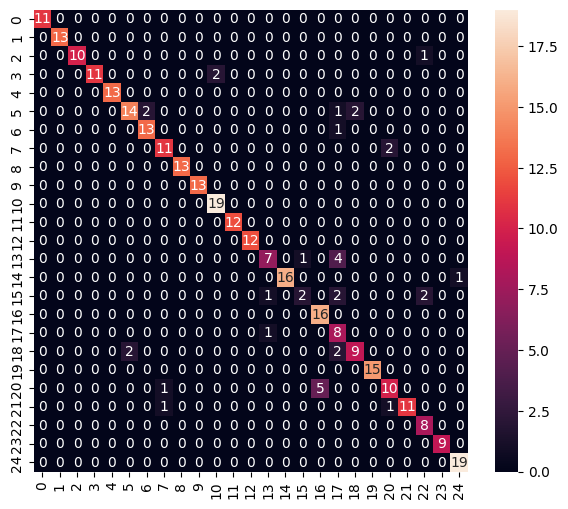

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        13
           2       1.00      0.91      0.95        11
           3       1.00      0.85      0.92        13
           4       1.00      1.00      1.00        13
           5       0.88      0.74      0.80        19
           6       0.87      0.93      0.90        14
           7       0.85      0.85      0.85        13
           8       1.00      1.00      1.00        13
           9       1.00      1.00      1.00        13
          10       0.90      1.00      0.95        19
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00        12
          13       0.78      0.58      0.67        12
          14       1.00      0.94      0.97        17
          15       0.67      0.29      0.40         7
          16       0.76      1.00      0.86        16
     

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [51]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        11
           1      1.000     1.000     1.000        13
           2      1.000     0.909     0.952        11
           3      1.000     0.846     0.917        13
           4      1.000     1.000     1.000        13
           5      0.875     0.737     0.800        19
           6      0.867     0.929     0.897        14
           7      0.846     0.846     0.846        13
           8      1.000     1.000     1.000        13
           9      1.000     1.000     1.000        13
          10      0.905     1.000     0.950        19
          11      1.000     1.000     1.000        12
          12      1.000     1.000     1.000        12
          13      0.778     0.583     0.667        12
          14      1.000     0.941     0.970        17
          15      0.667     0.286     0.400         7
          16      0.762     1.000     0.865        16
          17      0.444    